In [1]:
from nonasymptotic.envs import StraightLine
from nonasymptotic.prm import SimplePRM

import matplotlib.pyplot as plt
import numpy as np

In [2]:
seed = 1
prm_env_2d = StraightLine(dim=2, delta_clearance=0.5, seed=seed)
prm = SimplePRM(0.10, prm_env_2d.is_motion_valid, prm_env_2d.sample_from_env, prm_env_2d.distance_to_path, seed=seed)
prm.grow_to_n_samples(10000)

# plt.figure()
# for u, v in prm.g_prm.iterEdges():
#     coords_u = prm.samples[u]
#     coords_v = prm.samples[v]
# 
#     plt.plot([coords_u[0], coords_v[0]], [coords_u[1], coords_v[1]], 'ro-')
# 
# plt.show()

# some other computations to help other visual tests later on:
print('N Components: %i' % len(prm.g_cc.getComponents()))
print('N nodes: %i' % prm.num_vertices())
print('N edges: %i' % prm.num_edges())


N Components: 1
N nodes: 10000
N edges: 744710


In [3]:
# do some connection queries with some existing points
s = np.array([0., 0.])
g = np.array([1., 0.])

sol_dist, sol_path = prm.query_best_solution(s, g)
sol_path = np.concatenate([[s], sol_path, [g]])

# plt.figure()
# 
# # plot the existing prm
# for u, v in prm.g_prm.iterEdges():
#     coords_u = prm.samples[u]
#     coords_v = prm.samples[v]
# 
#     plt.plot([coords_u[0], coords_v[0]], [coords_u[1], coords_v[1]], 'ro-')
# 
# for i in range(sol_path.shape[0] - 1):
#     u = sol_path[i]
#     v = sol_path[i + 1]
#     plt.plot([u[0], v[0]], [u[1], v[1]], 'bo-')
# 
# plt.plot()
print('N nodes: %i' % prm.num_vertices())
print('N edges: %i' % prm.num_edges())


N nodes: 10000
N edges: 744710


In [4]:
pairs, _, _ = prm.query_all_graph_connections(s, g)
# plt.figure()

# plot the existing prm
# for u, v in prm.g_prm.iterEdges():
#     coords_u = prm.samples[u]
#     coords_v = prm.samples[v]
# 
#     plt.plot([coords_u[0], coords_v[0]], [coords_u[1], coords_v[1]], 'ro-')
# 
# for u, v in pairs:
#     plt.plot([u[0], v[0]], [u[1], v[1]], 'bo-')
# 
# plt.show()


In [5]:
import time
t_start = time.process_time()
prm_env_2d.is_prm_epsilon_delta_complete(prm, 0.75, n_samples_per_check=500, timeout=30.0, vis=True)
t_end = time.process_time()
print(t_end - t_start)

full cover!
38.235031692999996


In [ ]:
start = np.array([0.00506189, 0.0])
goal = np.array([0.10611559, 0.0])

dist, path = prm.query_best_solution(start, goal)
print(dist - (1 + 0.5) * (goal[0] - start[0]))

print(np.linalg.norm(path[0] - path[1]))
sol_pts, sol_dists = prm.query_all_graph_connections(start, goal)
is_best_pair = np.all(np.equal(sol_pts, np.array([path[0], path[1]])), axis = (1, 2))
print(sol_dists[is_best_pair] - np.linalg.norm(path[0] - path[1]))

start_norms = np.linalg.norm(prm.samples - start, axis = 1)
start_selector = start_norms <= 0.1
all_neighbors_start = np.arange(1000)[start_selector]
start_sort = np.argsort(start_norms[start_selector])

goal_norms = np.linalg.norm(prm.samples - goal, axis=-1)
goal_selector = goal_norms <= 0.1
all_neighbors_goal = np.arange(1000)[goal_selector]
goal_sort = np.argsort(goal_norms[goal_selector])


In [ ]:
print(prm.nn_index.query([start], k=15)[0][0])
print(all_neighbors_start[start_sort])
print(prm.nn_index.query([start], k=15)[1][0])
print(np.sort(start_norms[start_selector]))


print(prm.nn_index.query([goal], k=19)[0][0])
print(all_neighbors_goal[goal_sort])
print(prm.nn_index.query([goal], k=19)[1][0])
print(np.sort(goal_norms[goal_selector]))

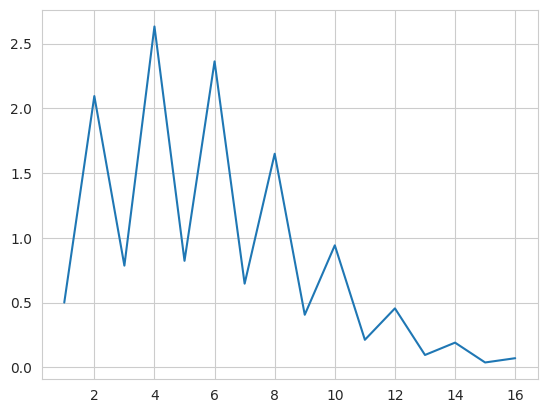

In [13]:
# volume sphere generator
def compute_vol_to_nd(rad, d):
    res = np.zeros(d + 1)
    res[0] = 1
    res[1] = 2 * rad
    
    for i in range(2, d + 1):
        res[i] = 2 * np.pi / (i + 1) * res[i - 2]
        
    return res[1:]


vols = compute_vol_to_nd(0.25, 16)
plt.figure()
plt.plot(range(1, 17), vols)
plt.show()
    